In [52]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [53]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.
        
    Provenance:
        [https://scitools.org.uk/iris/docs/v1.2/examples/graphics/SOI_filtering.html]

    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

In [54]:
def wgt_runave(darr, wgt, dim):
    """Apply weighted running average over dimension dim (int or str) of DataArray darr.
    
    darr:
        DataArray
    
    wgt:
        The weights to apply.
        
    dim:
        The dimension to filter. Can be either the name of the dimension as string, or the index of it as integer.
    
    Description:
        This is the same implementation that we used in filters_1.ipynb.
    
    """
    if isinstance(dim, int):
        axis = dim
    elif isinstance(dim, str):
        if dim in darr.dims:
            axis = darr.dims.index(dim)
    else:
        raise IOError(f"How to interpretet dim = {dim}")
            
    r = np.apply_along_axis(lambda m: np.convolve(m, wgt, mode='same'), axis=axis, arr=darr)
    # copy coordinates from tmp:
    r = xr.DataArray(r, dims=darr.dims, coords=darr.coords)
    r.name = darr.name
    r.attrs = darr.attrs
    r.attrs['processing'] = "Smoothed by wgt_runave."
    return r

In [55]:
fil = "/Users/brianpm/Documents/www.ncl.ucar.edu/Applications/Data/cdf/SOI_Darwin.nc"
ds = xr.open_dataset(fil)
dsoi  = ds['DSOI']
dsoi

<xarray.DataArray 'DSOI' (time: 1404)>
array([0. , 0.4, 0.2, ..., 1.1, 1.6, 1.3], dtype=float32)
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 7 ... 1397 1398 1399 1400 1401 1402 1403
Attributes:
    short_name:  DSOI
    long_name:   Darwin Southern Oscillation Index
    units:       dimensionless

In [57]:
# The NCL example has 4 different filters applied and compared. 
# We do the same here, but just to be compact, we use a named tuple (though regular tuple would work fine)
# - make a dictionary with all 4 filter specifications (params).
# - do a dictionary comprehension to make a new dictionary with the same keys and values are the weights.

from collections import namedtuple

FilterParam = namedtuple('FilterParam' , ['size', 'freq'])

params = {"n49f2": FilterParam(49, 1/24), 
          "n121f2": FilterParam(121, 1/24), 
          "n121f10": FilterParam(121, 1/120), 
          "n241f10": FilterParam(241, 1/120)}

wgts = {p: low_pass_weights(params[p].size, params[p].freq) for p in params}

In [58]:
# - then another dictionary comprehension that applies the filter
#   and makes a dictionary with same keys and filtered time series as values.
dsoi_filtered = {w: wgt_runave(dsoi, wgts[w], 'time') for w in wgts}

In [59]:
# dsoi["time"]  # units "Months Since January 1882" ... This is not really an okay unit

# Option 1: use pandas to create a nice set of dates
# import pandas as pd
# time_pd = pd.date_range('1882-01-01', periods=len(dsoi.time), freq='M')

# Option 2: Just convert to year.frac:
yrfrac = 1882 + dsoi["time"].values / 12

# Choose option 2 because we just need it for plot.

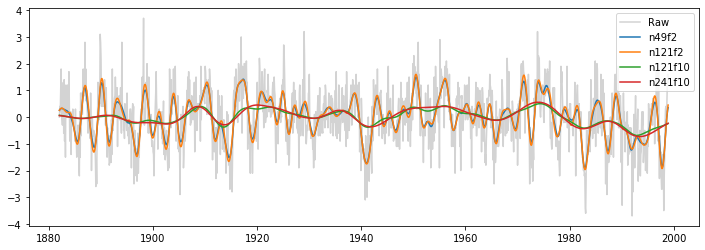

In [61]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(yrfrac, dsoi, color='lightgray', label='Raw')
[ax.plot(yrfrac, dsoi_filtered[d], label=d) for d in dsoi_filtered]
ax.legend()

# Notes

I apparently don't have the same file as the one used for the NCL example. First, theirs is called SOI.nc; I have one like that, but it doesn't have a variable called `SOI_DARWIN`. Theirs goes farther than mine in time.

The filter function comes directly from the Iris documentation. It provides a lowpass filter, but does not implement the bandpass capability of NCL's function.

Also, the convolution method we use does not lose data at the ends of the time series. That's not to say we should trust those values, but values are produced.